In [1]:
from PIL import Image
import depth_pro

import torch

import os
torch.cuda.is_available()
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load model and preprocessing transform
model, transform = depth_pro.create_model_and_transforms()
model.eval()
model = model.to("cuda:0")
print("Model loaded...")

print(f"The device is: {model.encoder.patch_encoder.patch_embed.proj.weight.device}...")

Model loaded...
The device is: cuda:0...


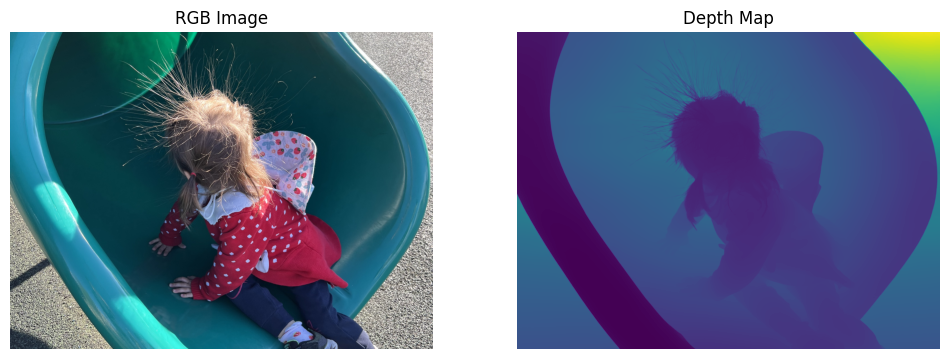

In [3]:
def inference(image_path):
    # Load and preprocess an image.
    image, _, f_px = depth_pro.load_rgb(image_path)
    image = transform(image)
    image = image.to("cuda:0")
    with torch.amp.autocast('cuda'):  # Enables FP16 inference
        prediction = model.infer(image, f_px=f_px)
    depth = prediction["depth"]  # Depth in [m].
    focallength_px = prediction["focallength_px"]  # Focal length in pixels.
    return depth, focallength_px

# Load your RGB image
def visualize_results(image_path, depth):
    image = Image.open(image_path)
    
    # Convert depth map to numpy for visualization
    depth_map_np = depth.cpu().numpy()
    
    # Normalize depth map for better visualization
    depth_map_normalized = (depth_map_np - depth_map_np.min()) / (depth_map_np.max() - depth_map_np.min())
    
    # Plot the images side by side
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Show the original image
    axes[0].imshow(image)
    axes[0].set_title("RGB Image")
    axes[0].axis("off")
    
    # Show the depth map (use colormap for better visibility)
    axes[1].imshow(depth_map_normalized, cmap="viridis")
    axes[1].set_title("Depth Map")
    axes[1].axis("off")
    
    plt.show()

image_path = "data/example.jpg"
depth, focallength_px = inference(image_path)
visualize_results(image_path=image_path, depth=depth)

In [4]:
image_sizes = [(512, 512), (1024, 1024), (1920, 1080), (2268, 3024)]
num_runs = 20  # Number of repetitions per image size
warmup_runs = 5

for size in image_sizes:
    print(f"Running inference for image size: {size}")

    # Resize image
    image = Image.open(image_path).resize(size)
    temp_image_path = "temp_resized.jpg"
    image.save(temp_image_path)

    times = []

    for nr in range(num_runs):
        # Ensure synchronization before starting timing
        torch.cuda.synchronize()

        # CUDA events for precise timing
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)

        start_event.record()
        depth, focallength_px = inference(temp_image_path)
        end_event.record()

        # Synchronize to ensure accurate timing
        torch.cuda.synchronize()

        # Compute elapsed time in milliseconds
        elapsed_time = start_event.elapsed_time(end_event)      

        if nr > warmup_runs:
            times.append(elapsed_time)

    mean_time = np.mean(times)
    std_time = np.std(times)

    print(f"Inference time for {size}: {mean_time:.2f} ± {std_time:.2f} ms\n")


Running inference for image size: (512, 512)
Inference time for (512, 512): 548.35 ± 5.30 ms

Running inference for image size: (1024, 1024)
Inference time for (1024, 1024): 594.07 ± 16.97 ms

Running inference for image size: (1920, 1080)
Inference time for (1920, 1080): 623.74 ± 4.52 ms

Running inference for image size: (2268, 3024)
Inference time for (2268, 3024): 697.49 ± 14.22 ms



## Image size and performance

| Image Size      | Inference Time (ms) | Std Dev (ms) |
|---------------|-------------------|-------------|
| (512, 512)   | 547.06            | ±2.49       |
| (1024, 1024) | 593.40            | ±9.39       |
| (1920, 1080) | 638.44            | ±6.34       |
| (2268, 3024) | 699.48            | ±1.97       |


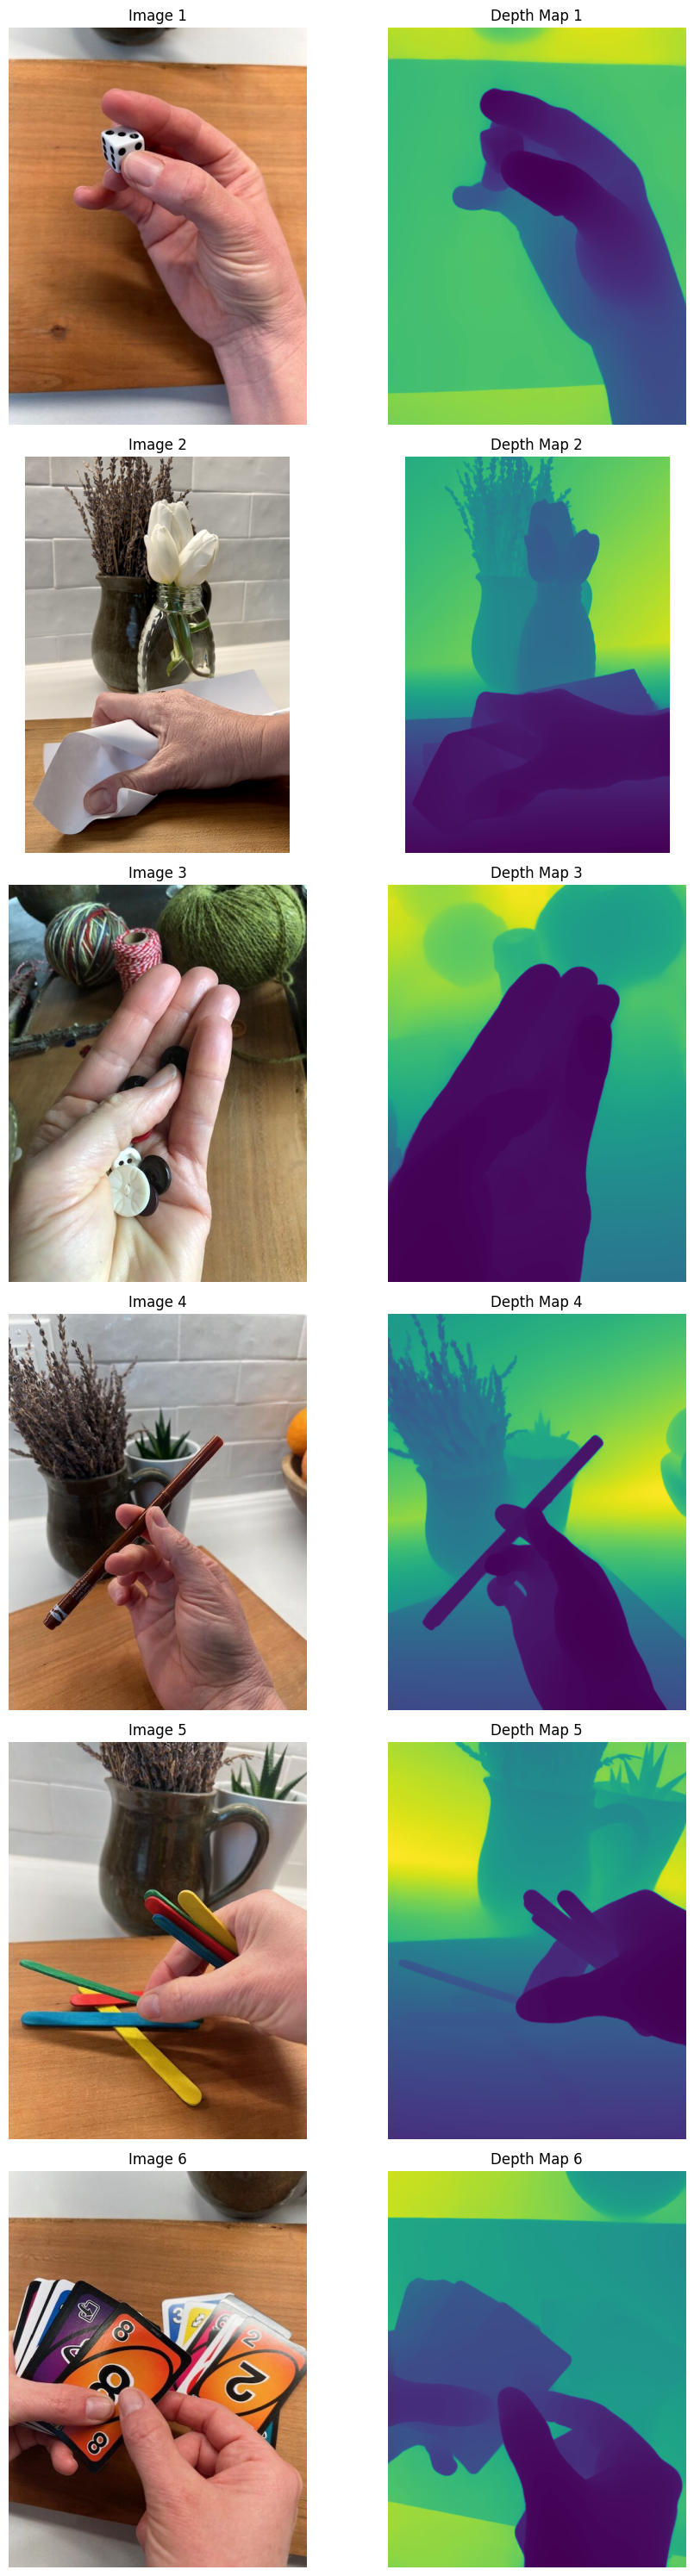

In [5]:
# Directory containing images
image_dir = "data/hands"
image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith((".jpg", ".png"))]

# Define grid size: each row contains (Image, Depth Map) pairs
num_cols = 2
num_rows = len(image_paths)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))

# Process and display each image with its depth map
for i, image_path in enumerate(image_paths):
    depth, _ = inference(image_path)  # Perform inference
    image = Image.open(image_path)  # Load image

    depth_np = depth.cpu().numpy() if isinstance(depth, torch.Tensor) else depth
    depth_min, depth_max = depth_np.min(), depth_np.max()
    if depth_max > depth_min:  # Avoid division by zero
        depth_np = (depth_np - depth_min) / (depth_max - depth_min)
   

    # Display original image
    ax1 = axes[i, 0] if num_rows > 1 else axes[0]
    ax1.imshow(image)
    ax1.axis("off")
    ax1.set_title(f"Image {i+1}")

    # Display normalized depth map
    ax2 = axes[i, 1] if num_rows > 1 else axes[1]
    ax2.imshow(depth_np, cmap="viridis")  # "viridis" for better visibility
    ax2.axis("off")
    ax2.set_title(f"Depth Map {i+1}")

plt.tight_layout()
plt.show()